## For random testing 

In [1]:
a = [[1,2,3],[4,5,6]]


In [2]:
import numpy as np

In [3]:
a = np.matrix('1 2 4; 3 4 5')
a.shape

(2, 3)

b = np.array([[1,2,3],[2,3,4]])
c = np.array([1,3])
b.sum(axis=0)

In [4]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
np.sum([[0, 1], [0, 5]], axis=1)

array([1, 5])

In [6]:
import pandas as pd

In [7]:
titanic = pd.read_csv("../data/titanic_train.csv")

In [8]:
titanic.head()
print(titanic[pd.core.series.Series.notnull(titanic.Embarked)])
print(titanic.dtypes)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25          

In [9]:
r"C:\Users\Bob\SecretPasswordFile.txt"

'C:\\Users\\Bob\\SecretPasswordFile.txt'

In [10]:
del titanic['PassengerId']
print(titanic)

     Survived  Pclass                                               Name  \
0           0       3                            Braund, Mr. Owen Harris   
1           1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2           1       3                             Heikkinen, Miss. Laina   
3           1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4           0       3                           Allen, Mr. William Henry   
5           0       3                                   Moran, Mr. James   
6           0       1                            McCarthy, Mr. Timothy J   
7           0       3                     Palsson, Master. Gosta Leonard   
8           1       3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
9           1       2                Nasser, Mrs. Nicholas (Adele Achem)   
10          1       3                    Sandstrom, Miss. Marguerite Rut   
11          1       1                           Bonnell, Miss. Elizabeth   
12          

In [11]:
titanic.describe()
titanic[titanic.Survived == 1].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,342.0,342.000000,290.000000,342.000000,342.000000,342.000000
mean,1.0,1.950292,28.343690,0.473684,0.464912,48.395408
std,0.0,0.863321,14.950952,0.708688,0.771712,66.596998
min,1.0,1.000000,0.420000,0.000000,0.000000,0.000000
25%,1.0,1.000000,19.000000,0.000000,0.000000,12.475000
50%,1.0,2.000000,28.000000,0.000000,0.000000,26.000000
75%,1.0,3.000000,36.000000,1.000000,1.000000,57.000000
max,1.0,3.000000,80.000000,4.000000,5.000000,512.329200


In [12]:
titanic[titanic.Survived == 0].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [13]:
import matplotlib.pyplot as plt

In [14]:
a = titanic[(titanic.Survived == 1) & (titanic.Sex == "male")]
#a = a[a.Sex == "male"]
b = titanic[(titanic.Survived == 1) & (titanic.Sex == "female")]
#b = b[b.Sex == "female"]

In [15]:
y = [len(a),len(b)]

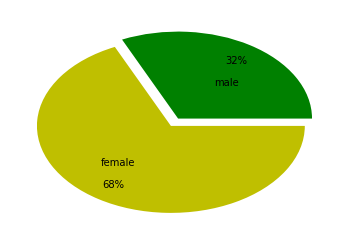

In [16]:
plt.pie(y,labels=["male","female"],labeldistance=0.5,colors=["g","y"], autopct='%1.0f%%',pctdistance=0.8,explode=[0,0.1])
plt.show()

In [17]:
print((titanic.Survived == 1).sum())

342


In [18]:
titanic[titanic.Sex == "male"]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
12,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
16,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
17,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S


In [19]:
t = titanic
print(type(t))
t[(t.Sex=="male") & (t.Survived == 1)]

<class 'pandas.core.frame.DataFrame'>


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
17,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
21,1,2,"Beesley, Mr. Lawrence",male,34.00,0,0,248698,13.0000,D56,S
23,1,1,"Sloper, Mr. William Thompson",male,28.00,0,0,113788,35.5000,A6,S
36,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
55,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
65,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
74,1,3,"Bing, Mr. Lee",male,32.00,0,0,1601,56.4958,NaN,S
78,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
81,1,3,"Sheerlinck, Mr. Jan Baptist",male,29.00,0,0,345779,9.5000,NaN,S
97,1,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C


In [20]:
a = np.ones((1,4,3))
#print("a = ",a)
b = np.ones((4,3,8))
#print("b = ",b)
print(np.matmul(a,b))
print("Shape is ",np.matmul(a,b).shape)
#sum(a[0,1,:] * b[0,:,1])

[[[ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.]]]
Shape is  (4, 4, 8)


In [21]:
a = np.array([1,2,3])
b = np.array([1,1,1])
a-b

array([0, 1, 2])

In [22]:
import pandas as pd
import numpy as np
import sklearn.datasets as Datasets
import sklearn.model_selection as cv
import matplotlib.pyplot as plt

In [23]:
def fitNormal(X_train,Y_train):
    #theta = (X.T * X).inv * X.T * Y_train
    X_train = np.c_[np.ones(len(X_train)),X_train]
    a = np.matmul(X_train.T,X_train)
    inverse = np.linalg.inv(a)
    b = np.matmul(inverse,X_train.T)
    theta = np.matmul(b,Y_train)
    return theta

In [24]:
def fitGradientDescent(X_train,Y_train,learning_rate=0.001,tolerance=0.0001,max_iterations=1000000): #X_train can be np 2D array
    n,fc = X_train.shape #fc is feature_count, n is no.of training samples
    #Setting x[0] as 1s
    X_train = np.c_[np.ones(n),X_train]
    #Now X_train's shape is (n,fc+1)
    
    #Initializing theta with shape (fc+1,1)
    theta = np.zeros((fc+1,1))
    #print("X shape is ",X_train.shape)
    #print("theta shape is ",theta.shape)
    
    J_theta = []
    iterations = []
    count = 0
    error_value = (((np.matmul(X_train,theta) - Y_train)*(np.matmul(X_train,theta) - Y_train)).sum()/n)
    while(error_value >= tolerance and count <= max_iterations):
        #Updating parameters based on formula and maths
        theta_derivative =  (np.matmul(X_train.T,(np.matmul(X_train,theta) - Y_train)))/n # (fc+1,n)*(n,1) = (fc+1,1)
        theta = theta - theta_derivative*learning_rate
        #For plotting curve of error value vs no. of iterations
        J_theta.insert(len(J_theta),error_value) 
        iterations.insert(len(iterations),count)
        
        #Updated error value with new values of parameters and iteration count
        error_value = (((np.matmul(X_train,theta) - Y_train)**2).sum()/n)
        count = count + 1
        
    print("Stopped after",count,"iterations")
    plt.plot(iterations,J_theta) 
    plt.show() #Should be decreasing for checking correct movement of gradient descent
    return theta

In [25]:
def predict(X_test,theta):
    X_test = np.c_[np.ones(X_test.shape[0]),X_test]
    return np.matmul(X_test,theta)

In [26]:
def score(Y_true,Y_predicted):
    nr = ((Y_true - Y_predicted)*(Y_true-Y_predicted)).sum()
    dr = ((Y_true - Y_true.mean())*(Y_true-Y_true.mean())).sum()
    result = 1 - (nr/dr)
    return result

In [27]:
def scaledCopy(dataframe):
    df_scaled = dataframe.copy()
    for i in range(len(df_scaled.columns)):
        df_scaled[i] = df_scaled[i]/df_scaled[i].max()
    return df_scaled

In [28]:
boston = Datasets.load_boston()
df = pd.DataFrame(boston.data)

In [29]:
X_test, X_train, Y_test, Y_train = cv.train_test_split(df,boston.target,test_size=0.2)
X_test_scaled = scaledCopy(X_test)
X_train_scaled = scaledCopy(X_train)

In [30]:
X_test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.554361,11.944307,11.118589,0.069307,0.550947,6.299280,68.031931,3.829399,9.643564,411.245050,18.539356,358.650792,12.545767
std,8.349088,23.755501,6.901793,0.254290,0.113805,0.686209,28.291098,2.124127,8.743757,169.672614,2.124888,88.736301,7.039303
min,0.009060,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.079365,0.000000,5.130000,0.000000,0.448000,5.888000,44.850000,2.106075,4.000000,281.000000,17.400000,375.782500,6.987500
50%,0.234405,0.000000,9.690000,0.000000,0.535000,6.209000,76.850000,3.157500,5.000000,334.500000,19.100000,391.475000,11.395000
75%,3.694070,20.000000,18.100000,0.000000,0.624000,6.616500,93.825000,5.214600,24.000000,666.000000,20.200000,396.292500,16.945000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Score for Unscaled DF Normal Equation =  0.649765229789
Stopped after 1000001 iterations


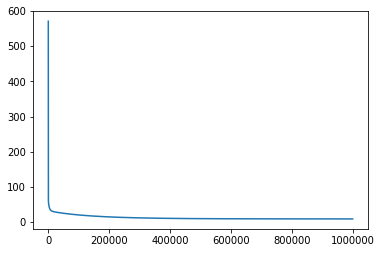

Score for Unscaled Gradient Descent =  0.63300712041


In [31]:
theta = fitNormal(X_train,Y_train.reshape(len(Y_train),1))
Y_predicted = predict(X_test,theta)
print("Score for Unscaled DF Normal Equation = ",score(Y_test,Y_predicted.reshape(len(Y_predicted))))
theta = fitGradientDescent(X_train,Y_train.reshape(len(Y_train),1),0.000006,max_iterations=1000000)
Y_predicted = predict(X_test,theta)
print("Score for Unscaled Gradient Descent = ",score(Y_test,Y_predicted.reshape(len(Y_predicted))))

Score for Scaled DF Normal Equation =  0.643620364485
Stopped after 1000001 iterations


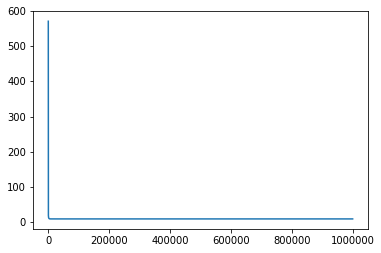

Score for Scaled Gradient Descent =  0.643620364485


In [32]:
theta = fitNormal(X_train_scaled,Y_train.reshape(len(Y_train),1))
Y_predicted = predict(X_test_scaled,theta)
print("Score for Scaled DF Normal Equation = ",score(Y_test,Y_predicted.reshape(len(Y_predicted))))
theta = fitGradientDescent(X_train_scaled,Y_train.reshape(len(Y_train),1),0.1,max_iterations=1000000) #Now we can increase learning rate as it won't cause integer overflow while multiplications
Y_predicted = predict(X_test_scaled,theta)
print("Score for Scaled Gradient Descent = ",score(Y_test,Y_predicted.reshape(len(Y_predicted))))

In [33]:
iris = Datasets.load_iris()
df = pd.DataFrame(iris.data)
list(set(iris.target))

[0, 1, 2]

# Trying Backward Elimination with StartUps Profit Dataset

In [34]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression

## Data Preprocessing

- Load the data

In [35]:
data = pd.read_csv("../data/50_Startups.csv")
X = data.iloc[:,:-1].values
Y = data.iloc[:,-1].values

- Label Encoding to change strings to integers

In [36]:
labelEncoder_X = LabelEncoder()
X[:,3] = labelEncoder_X.fit_transform(X[:,3])

- One Hot Encoding to change categorical integers to dummy variables

In [37]:
oneHotEncoder = OneHotEncoder(categorical_features = [3])
X = oneHotEncoder.fit_transform(X).toarray()

 - Avoiding Dummy Variable Trap

In [38]:
#Taking one less dummy variable from each set of categorical dummy variables
X = X[:,1:]

In [39]:
X_train, X_test, Y_train, Y_test = cv.train_test_split(X,Y,test_size=0.2,random_state=0)

In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
regressor = LinearRegression()
regressor.fit(X_train,Y_train)
Y_pred = regressor.predict(X_test)
score(Y_test,Y_pred) #Score with all-in model

0.93470684732824461

### Step 1

In [42]:
#Adding column of 1s for constant
X = np.append(arr = np.ones((X.shape[0],1)).astype(int),values = X,axis=1)
significance_level = 0.05

### Step 2

In [43]:
included_columns = [i for i in range(X.shape[-1])]

### Step 3 and Step 4

In [44]:
finished = False
while not finished:
    X_opt = X[:,included_columns]
    regressor_OLS = sm.OLS(endog=Y,exog=X_opt).fit()
    #print(regressor_OLS.summary())
    table_data = regressor_OLS.summary().tables[1].data
    p_values = [float(table_data[i][4]) for i in range(1,len(table_data))]
    if(max(p_values) > 0.05): 
        column_to_remove = p_values.index(max(p_values))
        #print("Removing column",included_columns[column_to_remove])
        del included_columns[column_to_remove]
    else:
        finished = True

### Step 5 

In [45]:
#Modifying X according to results of backward elimination
X = X[:,included_columns]
X_train, X_test, Y_train, Y_test = cv.train_test_split(X,Y,test_size=0.2,random_state=0)
regressor = LinearRegression()
regressor.fit(X_train,Y_train)
Y_pred = regressor.predict(X_test)
score(Y_test,Y_pred) #Score with all-in model

0.94645876077872204

# Lecture 4 Test

In [46]:
data = pd.read_csv("../data/L4.csv",header=None)

In [47]:
X = data.values[:,[0]]
Y = data.values[:,[1]]

In [48]:
def fitGradientDescent(X_train,Y_train,learning_rate=0.001,tolerance=0.0001,max_iterations=1000000): #X_train can be np 2D array
    n,fc = X_train.shape #fc is feature_count, n is no.of training samples
    #Setting x[0] as 1s
    X_train = np.c_[np.ones(n),X_train]
    #Now X_train's shape is (n,fc+1)
    
    #Initializing theta with shape (fc+1,1)
    theta = np.zeros((fc+1,1))
    #print("X shape is ",X_train.shape)
    #print("theta shape is ",theta.shape)
    
    J_theta = []
    iterations = []
    count = 0
    error_value = (((np.matmul(X_train,theta) - Y_train)*(np.matmul(X_train,theta) - Y_train)).sum()/n)
    while(error_value >= tolerance and count <= max_iterations):
        #Updating parameters based on formula and maths
        theta_derivative =  (np.matmul(X_train.T,(np.matmul(X_train,theta) - Y_train)))/n # (fc+1,n)*(n,1) = (fc+1,1)
        theta = theta - theta_derivative*learning_rate
        if(count%(max_iterations//5) == 0):
            Y_pred = np.matmul(X_train,theta)
            plt.scatter(X_train[:,1:],Y_train,color="red")
            plt.plot(X_train[:,1:],Y_pred,color="blue")
            plt.show()
            plt.clf()
        #For plotting curve of error value vs no. of iterations
        J_theta.insert(len(J_theta),error_value) 
        iterations.insert(len(iterations),count)
        
        #Updated error value with new values of parameters and iteration count
        error_value = (((np.matmul(X_train,theta) - Y_train)**2).sum()/n)
        count = count + 1
        
    print("Stopped after",count,"iterations")
    plt.plot(iterations,J_theta) 
    plt.show() #Should be decreasing for checking correct movement of gradient descent
    return theta

In [49]:
X_train,X_test,Y_train,Y_test = cv.train_test_split(X,Y,test_size=0,random_state=0)
#Scaling
X_train[:,0] = X_train[:,0]/X_train[:,0].max()

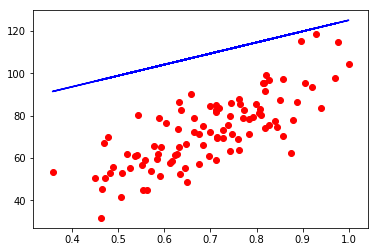

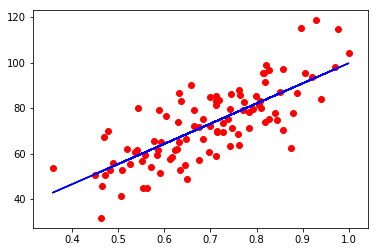

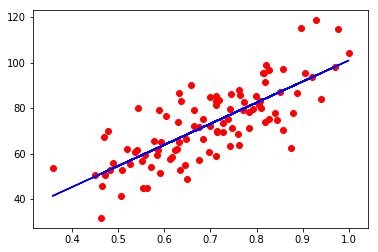

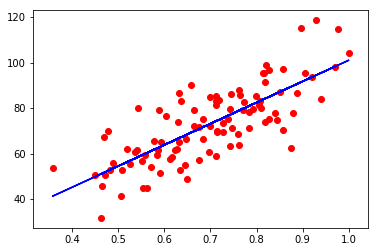

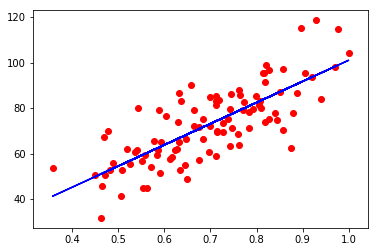

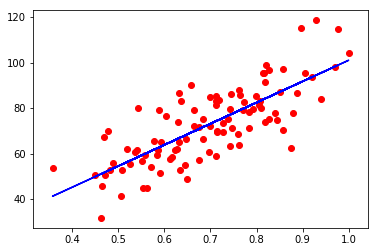

Stopped after 1001 iterations


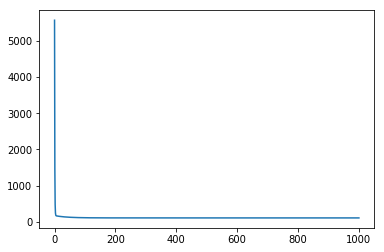

c =  7.99112974012
m =  93.0276784454


In [50]:
theta = fitGradientDescent(X_train,Y_train,1,max_iterations=1000)
print("c = ",theta[0][0])
print("m = ",theta[1][0])

In [51]:
regressor.fit(X_train,Y_train)
print("Slope = ",regressor.coef_[0][0])
print("Coeff = ",regressor.intercept_[0])

Slope =  93.0278327224
Coeff =  7.99102098227


In [52]:
diabetes = Datasets.load_diabetes()
df = pd.DataFrame(diabetes.data)

In [53]:
X = df.values
Y = diabetes.target

In [54]:
df_new = df.copy()

In [55]:
for i in range(0,len(df.columns)):
    for j in range(i,len(df.columns)):
        new_series = df.values[:,i] * df.values[:,j]
        new_column_name = str(i) + str(j)
        df_new[new_column_name] = new_series
        #pd.DataFrame.add(other=df_new,axis=1,fill_value=new_series,level=len(df_new.columns))
df_new.shape

(442, 65)

In [56]:
clf2 = LinearRegression()
X_new = df_new.values
Y_new = Y

In [57]:
X_train,X_test,Y_train,Y_test = cv.train_test_split(X_new,Y_new,test_size=0.2,random_state=0)

In [58]:
clf2.fit(X_train,Y_train)
Y_pred = clf2.predict(X_train)
clf2.score(X_train,Y_train)

0.63200275437590259

In [59]:
import math

In [60]:
a = np.array([[1.2],[2.5]])
np.round(a).astype(int)

array([[1],
       [2]])

# Kaggle Titanic

In [61]:
titanic_train = pd.read_csv("../data/Kaggle/Titanic/train.csv")
titanic_test = pd.read_csv("../data/Kaggle/Titanic/test.csv")
del titanic_train["PassengerId"]
del titanic_train["Name"]
del titanic_train["Ticket"]
del titanic_train["Cabin"]
del titanic_test["PassengerId"]
del titanic_test["Name"]
del titanic_test["Ticket"]
del titanic_test["Cabin"]

In [62]:
print(titanic_train.describe())
titanic_test.describe()
#now need to remove nan values from test and train data

         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


In [63]:
survived_mean_age = titanic_train[(pd.isnull(titanic_train.Age)==False) & titanic_train.Survived == 1].Age.mean()
print("Survived mean age in taininig data is = ",survived_mean_age)
not_survived_mean_age = titanic_train[(pd.isnull(titanic_train.Age)==False) & titanic_train.Survived == 0].Age.mean()
print("Not Survived mean age in taininig data is = ",not_survived_mean_age)

Survived mean age in taininig data is =  28.343689655172415
Not Survived mean age in taininig data is =  30.62617924528302


In [64]:
titanic_train.loc[pd.isnull(titanic_train.Age) & (titanic_train.Survived == 1),'Age'] = survived_mean_age
titanic_train.loc[pd.isnull(titanic_train.Age) & (titanic_train.Survived == 0),'Age'] = not_survived_mean_age

titanic_test.loc[pd.isnull(titanic_test.Age),'Age'] = titanic_test.Age.mean()
titanic_test.loc[pd.isnull(titanic_test.Fare),'Fare'] = titanic_test.Fare.mean()

In [65]:
print(titanic_test.describe())
titanic_test.head()

           Pclass         Age       SibSp       Parch        Fare
count  418.000000  418.000000  418.000000  418.000000  418.000000
mean     2.265550   30.272590    0.447368    0.392344   35.627188
std      0.841838   12.634534    0.896760    0.981429   55.840500
min      1.000000    0.170000    0.000000    0.000000    0.000000
25%      1.000000   23.000000    0.000000    0.000000    7.895800
50%      3.000000   30.272590    0.000000    0.000000   14.454200
75%      3.000000   35.750000    1.000000    0.000000   31.500000
max      3.000000   76.000000    8.000000    9.000000  512.329200


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [66]:
print(titanic_train.describe())
titanic_train.head()

         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.750072    0.523008    0.381594   32.204208
std      0.486592    0.836071   13.010682    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   22.000000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   30.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   35.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [67]:
titanic_train.dropna(inplace = True) #Dropping where embarked = Nan

In [68]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
X_train = titanic_train.values[:,1:]
Y_train = titanic_train.values[:,0].astype(int)
X_test = titanic_test.values[:,0:]

In [69]:
#Label Encoding

labelEncoder_gender = LabelEncoder()
labelEncoder_port = LabelEncoder()
print(X_train[0])
print(X_test[0])
X_train[:,1] = labelEncoder_gender.fit_transform(X_train[:,1])
X_test[:,1] = labelEncoder_gender.transform(X_test[:,1])
X_train[:,6] = labelEncoder_port.fit_transform(X_train[:,6])
X_test[:,6] = labelEncoder_port.transform(X_test[:,6])
print(X_train[0])
print(X_test[0])

[3 'male' 22.0 1 0 7.25 'S']
[3 'male' 34.5 0 0 7.8292 'Q']
[3 1 22.0 1 0 7.25 2]
[3 1 34.5 0 0 7.8292 1]


In [70]:
#One Hot Encoding

oneHotEncoder = OneHotEncoder(categorical_features = [0,6]) #Not including gender as it only has 2 values
X_train = oneHotEncoder.fit_transform(X_train).toarray()
X_test = oneHotEncoder.transform(X_test).toarray()
print(X_train[0])
print(X_test[0])
X_train = np.delete(X_train, 2, 1)
X_train = np.delete(X_train, 4, 1)
X_test = np.delete(X_test, 2, 1)
X_test = np.delete(X_test, 4, 1)
print(X_train[0])
print(X_test[0])

[  0.     0.     1.     0.     0.     1.     1.    22.     1.     0.     7.25]
[  0.       0.       1.       0.       1.       0.       1.      34.5      0.
   0.       7.8292]
[  0.     0.     0.     0.     1.    22.     1.     0.     7.25]
[  0.       0.       0.       1.       1.      34.5      0.       0.
   7.8292]


In [71]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
print(X_train[0])
print(X_test[0])

[-0.56306042 -0.51087465 -0.48271079 -0.30794088  0.73534203 -0.59402797
  0.43135024 -0.47432585 -0.50023975]
[-0.56306042 -0.51087465 -0.48271079  3.24737656  0.73534203  0.36973797
 -0.47519908 -0.47432585 -0.48857868]


In [72]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=0)
classifier.fit(X_train,Y_train)
pred_y_train = classifier.predict(X_train)

In [73]:
def accuracy(predicted_result,actual_result):
    count = 0
    for i in range(0,len(predicted_result)):
        if(int(predicted_result[i]) == actual_result[i]):
            count = count + 1
    return (count/len(predicted_result))

In [74]:
Y_pred = classifier.predict(X_test)
result = pd.DataFrame()
result["PassengerId"] = np.arange(892,892+418)

In [75]:
result["Survived"] = Y_pred

In [76]:
result.to_csv("../data/Kaggle/Titanic/Y_test.csv",index = False)

In [77]:
from sklearn import datasets
from sklearn import tree
import pydotplus

In [78]:
iris = datasets.load_iris()
clf = tree.DecisionTreeClassifier()

In [79]:
clf.fit(iris.data,iris.target)
dot_data = tree.export_graphviz(clf,out_file= None)

graph = pydotplus.graph_from_dot_data(dot_data)
#graph.write_pdf("iris.pdf")

In [80]:
from sklearn import naive_bayes
gnb = naive_bayes.GaussianNB()
gnb.fit(iris.data,iris.target)
y_pred = gnb.predict(iris.data)

In [81]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(iris.target,y_pred))
print(confusion_matrix(iris.target,y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.94      0.94      0.94        50
          2       0.94      0.94      0.94        50

avg / total       0.96      0.96      0.96       150

[[50  0  0]
 [ 0 47  3]
 [ 0  3 47]]


In [82]:
mnb = naive_bayes.MultinomialNB()
mnb.fit(iris.data,iris.target)
y_pred = mnb.predict(iris.data)

In [83]:
print(classification_report(iris.target,y_pred))
print(confusion_matrix(iris.target,y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.94      0.92      0.93        50
          2       0.92      0.94      0.93        50

avg / total       0.95      0.95      0.95       150

[[50  0  0]
 [ 0 46  4]
 [ 0  3 47]]


In [84]:
import quandl

In [85]:
df = quandl.get("WIKI/GOOGL")

In [86]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [87]:
del df["Open"], df["High"], df["Low"], df["Close"], df["Volume"], df["Split Ratio"], df["Ex-Dividend"]

In [88]:
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [89]:
deltaDays = -5
df["Y_adj_open"] = df["Adj. Open"].shift(deltaDays)
df["Y_adj_close"] = df["Adj. Close"].shift(deltaDays)
df["Y_adj_high"] = df["Adj. High"].shift(deltaDays)
df["Y_adj_low"] = df["Adj. Low"].shift(deltaDays)
df["Y_adj_vol"] = df["Adj. Volume"].shift(deltaDays)

In [90]:
df.dropna().tail()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Y_adj_open,Y_adj_close,Y_adj_high,Y_adj_low,Y_adj_vol
Date,,,,,,,,,,
2018-02-09,1025.88,1051.72,997.00,1043.43,4436032.0,1093.38,1095.50,1108.31,1091.55,1971928.0
2018-02-12,1056.67,1065.57,1045.49,1054.56,2796258.0,1092.76,1103.59,1116.29,1090.00,1646405.0
2018-02-13,1050.00,1061.22,1046.92,1054.14,1574121.0,1109.10,1113.75,1136.20,1107.51,2024534.0
2018-02-14,1054.32,1075.47,1049.80,1072.70,2029979.0,1119.17,1109.90,1125.46,1105.15,1386115.0
2018-02-15,1083.45,1094.10,1067.23,1091.36,1806206.0,1118.66,1128.09,1129.00,1108.44,1234539.0


In [91]:
X = df.iloc[:,0:5]
Y = df.iloc[:,5:]

In [93]:
Y

,Y_adj_open,Y_adj_close,Y_adj_high,Y_adj_low,Y_adj_vol
Date,,,,,
2004-08-19,52.637487,54.122070,54.142132,52.492038,7094800.0
2004-08-20,54.217364,53.239345,54.478169,53.008633,6211700.0
2004-08-23,52.802998,51.162935,52.908323,51.162935,5196700.0
2004-08-24,51.318415,51.343492,52.015567,51.238167,4917800.0
2004-08-25,51.509003,50.280210,51.644421,49.989312,9138200.0
2004-08-26,49.698414,50.912161,51.343492,49.623182,15118600.0
2004-08-27,50.631294,50.159839,51.027517,49.813770,5152400.0
2004-08-30,50.661387,50.947269,51.157920,49.959219,5847500.0
2004-08-31,50.525969,51.308384,51.674514,50.405597,4985600.0


# K Nearest Neighbours